## Предсказание эмоциональной окраски отзыва на основе анализа естественного языка (Практическая часть)

Вам для обработки предлагается коллекция рецензий пользователей на фильмы с сайта kinopoisk.ru

Положительных: 87101 

Отрицательных: 19804

Нейтральных: 24678


Все: 131583

Каждая рецензия в отдельном файле, первая часть названия файла соответствует ID фильма на kinopoisk.ru вторая часть номеру рецензии на этот фильм. Например, имя файла 306-15.txt обозначает идентификатор фильма на сайте 306, номер рецензии 15.

https://www.kaggle.com/mikhailklemin/kinopoisks-movies-reviews

[Прямая ссылка](https://www.kaggle.com/mikhailklemin/kinopoisks-movies-reviews/download) на скачивание данных.

Подключим необходимые библиотеки:

In [1]:
import pickle
import os
import re
import string
import warnings

import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

In [2]:
warnings.filterwarnings('ignore')

Для фильтрации нашего текста от мусора, загрузим список стоп-слов при помощи библиотки nltk:

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\StaroveR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Загрузка данных в датфрейм

Общий размер датасета (около 131к отзывов) - слишком большой, для памяти большинства компьютеров. Для дальнейших исследовалний взял 20% от обшего датасета, с сохранением пропорций классов.

In [4]:
# Доля отзывов, от обшего числа, с которыми будем работать в дальнейшем
prop = 0.2

path = './archive/dataset/'
df = pd.DataFrame(columns=['review','sentiment'])

for directory in os.listdir(path):
    if os.path.isdir(path + directory):
        dirs = np.array(os.listdir(path + directory))
        np.random.shuffle(dirs)
        rews_fhs = np.random.choice(dirs, round(len(dirs) * prop))
    
        for rew_fh in rews_fhs:
            with open(os.path.join(path + directory + '/', rew_fh), encoding='utf-8') as f:
                review = f.read()
                current_df = pd.DataFrame({'review': [review], 'sentiment': directory})
                df = df.append(current_df, ignore_index=True)

df = df.sample(frac=1).reset_index(drop=True) 

In [5]:
df.head(5)

,review,sentiment
0,Англичане любят подобные сюжеты: 'Таинственный...,pos
1,"Давно известно, что лучше сделать что-то медле...",neg
2,"У этого фильма, для меня, есть большущий минус...",neu
3,"Казалось бы, вот досмотрю я до конца фильм и н...",pos
4,Планируемая свадьба между двумя молодыми людьм...,neu


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26334 entries, 0 to 26333
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     26334 non-null  object
 1   sentiment  26334 non-null  object
dtypes: object(2)
memory usage: 411.6+ KB


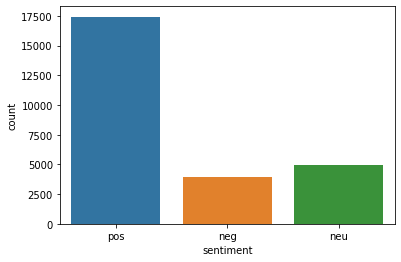

In [7]:
sns.countplot(df['sentiment'])

In [8]:
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

In [9]:
le.classes_

array(['neg', 'neu', 'pos'], dtype=object)

### Подготовка текстов

Форматирование текста, очистка от ненужных символов, приведение текста к нижнему регистру:

In [ ]:
def standardize_text(df, content_field):
    df[content_field] = df[content_field].str.replace(r"http\S+", "")
    df[content_field] = df[content_field].str.replace(r"@\S+", "")
    df[content_field] = df[content_field].str.replace(r"[^А-Яа-яA-Za-z0-9Ёё(),!?@\'\`\"\_\n]", " ")
    df[content_field] = df[content_field].str.replace(r"[Ёё]", "е")
    df[content_field] = df[content_field].str.replace(r"[\t\n]", "")
    df[content_field] = df[content_field].str.replace(r"[^А-Яа-яa-zA-Z]", " ")
    df[content_field] = df[content_field].str.lower()
    return df
#TODO: сокращения в полные слова

In [ ]:
standardize_text(df, "review")

Очистка текста от стоп-слов, применение стемминга (приведение оставшихся слов к основне):  
<b>P.S.</b> Процедура довольно долгая

In [ ]:
stemmer = SnowballStemmer('russian')
corpus = []

for i in range(len(df)):
    review = df['review'][i]
    review = review.split()
    review = [word for word in review if word not in set(stopwords.words('russian'))]
    review = [stemmer.stem(word) for word in review]
    review = ' '.join(review)
    corpus.append(review)

Т.к. предыдущие два этапа занимают довольно много времени, сохраним наш датасет и созданный корпус в отдельные файлы. В дальнейшем будем импортировать данные из этих файлов для ускорения разработки.

In [ ]:
# Сохранение

with open('dataframe.pickle', 'wb') as fh:
    pickle.dump(df, fh)

with open('corpus.pickle', 'wb') as fh:
    pickle.dump(corpus, fh)

In [10]:
# Загрузка

with open('corpus.pickle', 'rb') as f:
    corpus = pickle.load(f)
    
with open('dataframe.pickle', 'rb') as f:
    df = pickle.load(f)

При помощи TF-IDF проведем векторизацию корпуса на основе n-грамм:

In [11]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
X = tfidf.fit_transform(corpus)

In [12]:
X.shape

(26334, 2777275)

Разделим выборку на обучение и тест:

In [13]:
y = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Классификацию будем проводить при помощи метода опорных векторов:

In [14]:
classifier = LinearSVC()
classifier.fit(X_train, y_train)

LinearSVC()

In [15]:
y_pred = classifier.predict(X_test)

Оценим точность на тестовой выборке:

In [16]:
acc = accuracy_score(y_test, y_pred)
acc

0.7850768938674767

In [17]:
report = classification_report(y_test, y_pred)

In [18]:
print(report)

              precision    recall  f1-score   support

           0       0.80      0.59      0.68       822
           1       0.72      0.25      0.37       973
           2       0.79      0.98      0.87      3472

    accuracy                           0.79      5267
   macro avg       0.77      0.61      0.64      5267
weighted avg       0.78      0.79      0.75      5267



Некоторые получившиеся значения точности, при разных параметрах TF-IDF векторизации:
    
| N-gram range | Max Features | Accuracy |  
|--------------|--------------|----------|
| 1, 1         | None         | 0.77     |
| 2, 2         | None         | 0.72     |
| 3, 3         | None         | 0.71     |
| 4, 4         | None         | 0.71     |
| 1, 2         | None         | 0.79     |
| 1, 3         | None         | 0.77     |
| 1, 4         | None         | 0.75     |
| 2, 3         | None         | 0.71     |
| 1, 2         | 1000000      | 0.79     |
| 1, 2         | 50000        | 0.78     |

<b>Выводы:</b> Лучшая точность классификации отзывов при использовании TF-IDF векторизации и метода опорных векторов, равна 0.79. Хуже всего такая модель определяет нейтральные отзывы (точность равна 0.72, полнота - 0.25). Для дальнейшего увелечения точности классификации требуется использовать другие модели, например нейронные сети.